# 5-1 검증 세트, 전처리 과정

In [12]:
import numpy as np

## 테스트 세트 모델 튜닝

In [1]:
# 로지스틱 회귀로 모델 훈련, 평가 하기
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

In [2]:
# SGDClassifier 클래스로 훈련, 평가하기
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log',random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.8333333333333334

In [4]:
# 서포트 벡터 머신으로 모델 훈련, 평가하기
sgd = SGDClassifier(loss='hinge', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.9385964912280702

## 테스트 세트로 모델을 튜닝하면 실전에서 좋은 성능 기대 어렵다.

## 검증 세트 준비

In [5]:
# 데이터셋 준비
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

In [6]:
# 검증 세트 분할
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
print(len(x_train), len(x_val))

364 91


In [8]:
# 검증 세트 사용해 모델 평가
# 훈련 세트의 작아져서 score도 낮아짐
sgd = SGDClassifier(loss='log', random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_val, y_val)

0.6923076923076923

데이터 양이 너무 적은 경우 검증 세트를 나누지 않고 `교차 검증(cross validation)`을 사용하기도 한다.

## 데이터 전처리, 특성 스케일


### 특성 스케일
특성의 스케일(scale)의 차이가 클 경우 특정 알고리즘(스케일에 민감한 알고리즘)을 쓰는 모델의 성능에 영향을 준다.

## 스케일 조정 없이 모델 훈련

['mean perimeter' 'mean area']


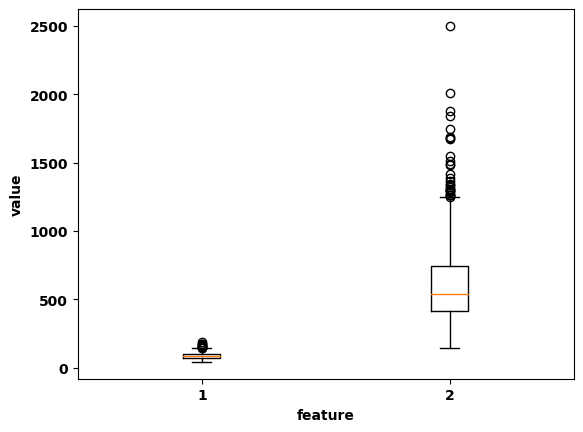

In [10]:
# 훈련 데이터 준비, 스케일 비교
import matplotlib.pyplot as plt

print(cancer.feature_names[[2, 3]])
plt.boxplot(x_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

SingleLayer에 가중치를 기록할 변수와 학습률 파라미터 추가
```py
def __init__(self, learning_rate=0.1):
    self.w = None
    self.b = None
    self.losses = []
    self.w_history = []
    self.lr = learning_rate
```

가중치 기록, 업데이트 양 조절
```py
def fit(self, x, y, epochs=100):
    self.w = np.ones(x.shape[1])
    self.b = 0
    
    # 가중치 기록
    self.w_history.append(self.w.copy())
    np.random.seed(42)

    for i in range(epochs):
        loss = 0
        indexes = np.random.permutation(np.arange(len(x)))
        for i in indexes:
            z = self.forpass(x[i])
            a = self.activation(z)
            err = -(y[i] - a)
            w_grad, b_grad = self.backprop(x[i], err)
            # 학습률 적용
            self.w -= self.lr * w_grad
            self.b -= b_grad

            # 가중치 기록
            self.w_history.append(self.w.copy())

            a = np.clip(a, 1e-10, 1-1e-10)

            loss += -(y[i]*np.log(a) + (1-y[i])*np.log(1-a))
        self.losses.append(loss/len(y))
```

In [17]:
# SingleLayer
class SingleLayer:
    def __init__(self, learning_rate=0.1) -> None:
        self.w = None
        self.b = None
        self.losses = []
        self.w_history = []
        self.lr = learning_rate

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b
        return z

    def backprop(self, x, err):
        w_grad = x * err
        b_grad = 1 * err
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None)
        a = 1 / (1 + np.exp(-z))
        return a

    def fit(self, x, y, epochs=100):
        self.w = np.ones(x.shape[1])
        self.b = 0
        
        # 가중치 기록
        self.w_history.append(self.w.copy())
        np.random.seed(42)

        for i in range(epochs):
            loss = 0
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:
                z = self.forpass(x[i])
                a = self.activation(z)
                err = -(y[i] - a)
                w_grad, b_grad = self.backprop(x[i], err)
                # 학습률 적용
                self.w -= self.lr * w_grad
                self.b -= b_grad

                # 가중치 기록
                self.w_history.append(self.w.copy())

                a = np.clip(a, 1e-10, 1-1e-10)

                loss += -(y[i]*np.log(a) + (1-y[i])*np.log(1-a))
            self.losses.append(loss/len(y))
            
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]
        return np.array(z) > 0

    def score(self, x, y):
        return np.mean(self.predict(x) == y)

In [18]:
# SingleLayer 모델 훈련, 평가
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

0.9120879120879121

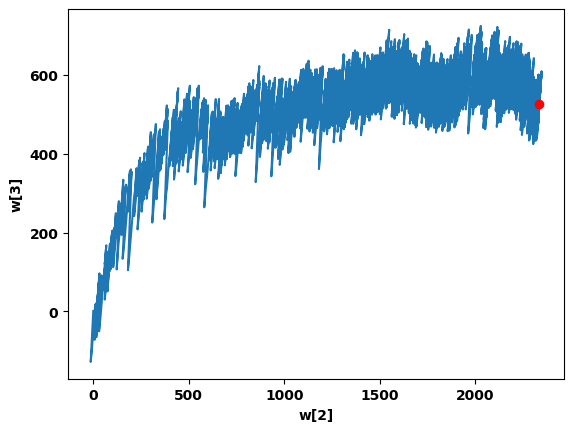

In [22]:
# layer1의 w_history 그리기
w2 = []
w3 = []
for w in layer1.w_history:
    w2.append(w[2])
    w3.append(w[3])

plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

w3의 그레디언트가 크기 때문에 w3 축을 따라 가중치가 크게 요동친다. 불안정하게 수렴한다.

## 스케일 조절 후 모델 훈련
스케일 조정 방법 중 1: 표준화(standardization)
$$
z = \frac{x-\mu}{s}
$$
* $\mu$: 평균
* $s$: 표준 편차
  * $s = \sqrt{\frac{1}{m} \sum_{i=0}^{m}(x_i - \mu)^2}$

In [23]:
x_train

array([[1.480e+01, 1.766e+01, 9.588e+01, ..., 8.308e-02, 3.600e-01,
        7.285e-02],
       [1.174e+01, 1.402e+01, 7.424e+01, ..., 8.290e-02, 3.101e-01,
        6.688e-02],
       [1.471e+01, 2.159e+01, 9.555e+01, ..., 1.834e-01, 3.698e-01,
        1.094e-01],
       ...,
       [1.444e+01, 1.518e+01, 9.397e+01, ..., 1.599e-01, 2.691e-01,
        7.683e-02],
       [1.742e+01, 2.556e+01, 1.145e+02, ..., 1.099e-01, 1.603e-01,
        6.818e-02],
       [1.143e+01, 1.731e+01, 7.366e+01, ..., 6.402e-02, 2.584e-01,
        8.096e-02]])

In [24]:
# 넘파이로 표준화 구현
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - train_mean) / train_std

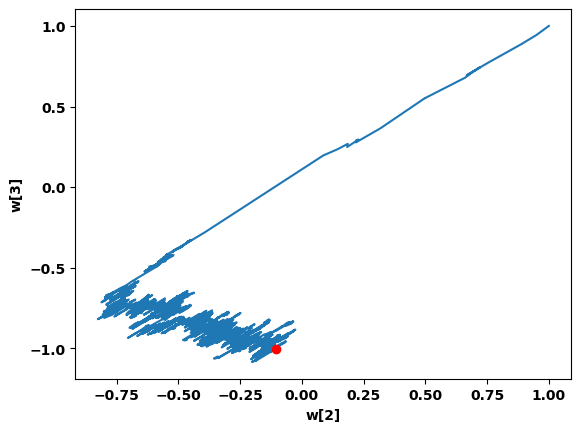

In [25]:
# 스케일 조정 후 모델 훈련
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)
w2 = []
w3 = []
for w in layer2.w_history:
    w2.append(w[2])
    w3.append(w[3])

plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

w2와 w3의 변화 비율이 비슷하기 때문에 대각선 방향으로 가중치 이동. 최적값에 빠르게 근접

In [26]:
# 모델 성능 평가
layer2.score(x_val, y_val)

0.37362637362637363

In [27]:
# 검증 세트 표준화
val_mean = np.mean(x_val, axis=0)
val_std = np.std(x_val, axis=0)
x_val_scaled = (x_val - val_mean) / val_std

In [28]:
layer2.score(x_val_scaled, y_val)

0.967032967032967

## 스케일 조정 후 실수하기 쉬운 함정


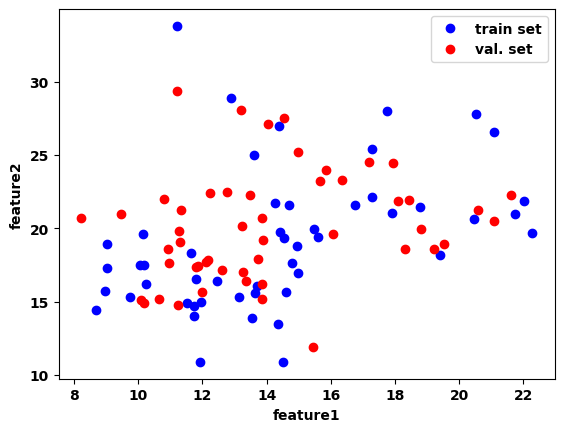

In [29]:
# 원본 훈련 세트와 검증 세트로 산점도 그리기
plt.plot(x_train[:50, 0], x_train[:50, 1], 'bo')
plt.plot(x_val[:50, 0], x_val[:50, 1], 'ro')
plt.xlabel('feature1')
plt.ylabel('feature2')
plt.legend(['train set', 'val. set'])
plt.show()

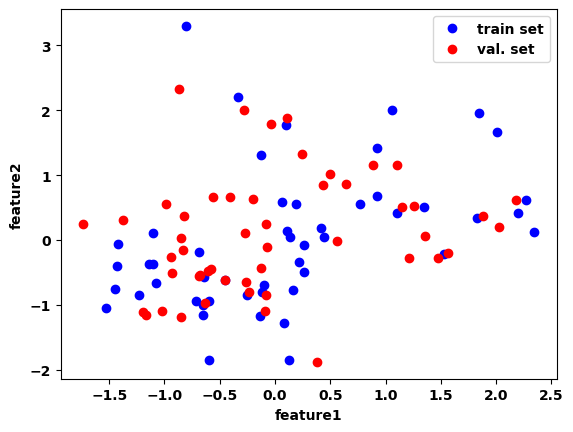

In [30]:
# 전처리(표준화)한 훈련 세트와 검증 세트 산점도
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature1')
plt.ylabel('feature2')
plt.legend(['train set', 'val. set'])
plt.show()

원본 그래프와 미세하게 다른 비율로 변환되었음을 볼 수 있다. 훈련 세트와 검증 세트를 각각 다른 비율로 전처리했기 때문

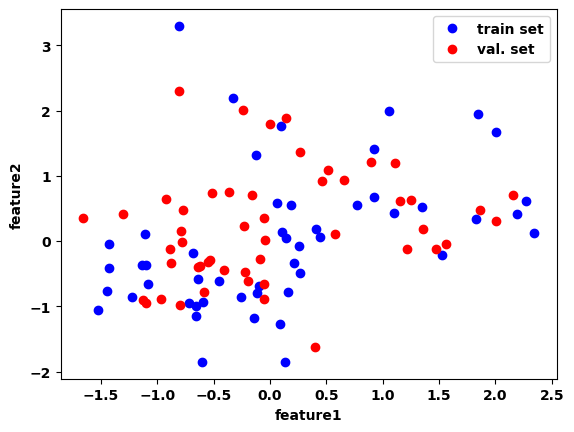

In [33]:
# 올바르게 검증 세트 전처리하기
x_val_scaled = (x_val - train_mean) / train_std
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], 'ro')
plt.xlabel('feature1')
plt.ylabel('feature2')
plt.legend(['train set', 'val. set'])
plt.show()
# 훈련 데이터와 동일한 비율로 변환되었다.

In [34]:
# 모델 평가(검증 세트와 훈련 세트 모두 동일한 비율로 스케일 조정)
layer2.score(x_val_scaled, y_val)

0.967032967032967

검증 세트가 클 경우 성능 차이 나타날 수 있음

# 5-2 과대적합 과소적합
overfitting, underfitting

## 
* 과대적합(overfitting): 훈련 세트에선 좋은 성능을 내지만 검증 세트에선 낮은 성능을 내는 경우
  * '분산이 크다(high variance)'
  * 모델 복잡도를 낮춰야함
* 과소적합(underfitting): 훈련 세트와 검증 세트의 성능에는 차이가 크지 않지만 모두 낮은 성능을 내는 경우
  * '편향이 크다(high bias)'
  * 모델 복잡도를 키워야함

모델 복잡도: 모델이 가진 학습 가능한 가중치 개수


## 적절한 편향-분산 트레이드오프 선택
`bias-variance tradeoff`: 편향을 줄이면 분산이 커지고 반대로 분산을 줄이면 편향이 커지는 것

### 검증 손실을 기록하기 위한 변수 추가
```py
def __init__(self, learning_rate=0.1):
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses = []
    self.w_history = []
    self.lr = learning_rate
```

### 검증 세트 전달
```py
def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    self.w = np.ones(x.shape[1])
    self.b = 0
    self.w_history.append(self.w.copy())
    np.random.seed(42)

    for i in range(epochs):
        loss = 0
        indexes = np.random.permutation(np.arange(len(x)))
        for i in indexes:
            z = self.forpass(x[i])
            a = self.activation(z)
            err = -(y[i] - a)
            w_grad, b_grad = self.backprop(x[i], err)
            self.w -= self.lr * w_grad
            self.b -= b_grad
            # 가중치 기록
            self.w_history.append(self.w.copy())

            a = np.clip(a, 1e-10, 1-1e-10)
            loss += -(y[i]*np.log(a) + (1-y[i])*np.log(1-a))

        self.losses.append(loss/len(y))
        # 검증 세트에 대한 손실 계산
        self.update_val_loss(x_val, y_val)
```

### 검증 손실 계산
```py
def update_val_loss(self, x_val, y_val):
    if x_val is None:
        return
    
    val_loss = 0
    for i in range(len(x_val)):
        z = self.forpass(x_val[i])
        a = self.activation(z)
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss += -(y_val[i]*np.log(a) + (1-y_val[i])*np.log(1-a))

    self.val_losses.append(val_loss/len(y_val))
```

### 모델

In [41]:
# SingleLayer
class SingleLayer:
    def __init__(self, learning_rate=0.1) -> None:
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b
        return z

    def backprop(self, x, err):
        w_grad = x * err
        b_grad = 1 * err
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None)
        a = 1 / (1 + np.exp(-z))
        return a

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy())
        np.random.seed(42)

        for i in range(epochs):
            loss = 0
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:
                z = self.forpass(x[i])
                a = self.activation(z)
                err = -(y[i] - a)
                w_grad, b_grad = self.backprop(x[i], err)
                self.w -= self.lr * w_grad
                self.b -= b_grad
                # 가중치 기록
                self.w_history.append(self.w.copy())

                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a) + (1-y[i])*np.log(1-a))

            self.losses.append(loss/len(y))
            # 검증 세트에 대한 손실 계산
            self.update_val_loss(x_val, y_val)
            
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]
        return np.array(z) > 0

    def score(self, x, y):
        return np.mean(self.predict(x) == y)

    def update_val_loss(self, x_val, y_val):
        if x_val is None:
            return
        
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val[i])
            a = self.activation(z)
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a) + (1-y_val[i])*np.log(1-a))

        self.val_losses.append(val_loss/len(y_val))

### 모델 훈련

In [36]:
# 모델 훈련
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

### 손실값 그래프 그리기

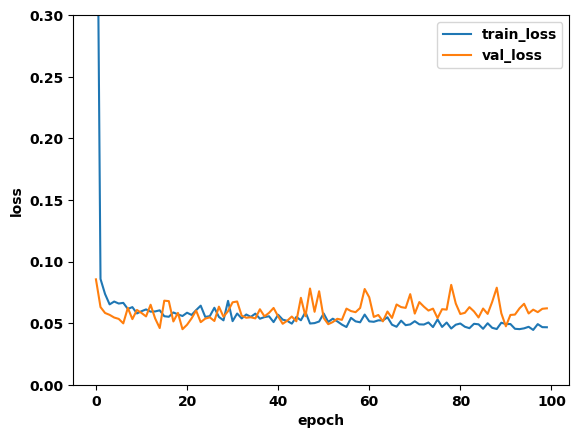

In [37]:
# 손실값 그래프를 그려 에포크횟수 정하기
plt.ylim(0, 0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

검증 손실이 대략 20번째 에포크 이후 훈련 세트보다 높아지는 것을 볼 수 있음

### 훈련 조기 종료(early stopping)
20번의 에포크까지 모델 훈련

In [40]:
layer4 = SingleLayer()
layer4.fit(x_train_scaled, y_train, epochs=20)
layer4.score(x_val_scaled, y_val)

0.978021978021978

# 5-3 규제 방법을 배우고 단일층 신경망에 적용

과대적합 해결 방법 중 1: 가중치 규제(regularization)

모델이 몇 개의 데이터에 집착할 때 가중치 규제를 사용하여 가중치를 제한하면 집착하지 않게 되며 일반화 성능을 높일 수 있다.

## L1 규제
손실 함수에 가중치의 절댓값(`L1 노름(norm)`)을 추가한다. 

식
$$
||w||_1 = \sum_{i=1}^{n} |w_i|
$$

로지스틱 손실 함수에 L1 규제 적용
$$
L = -(y\log (a) + (1-y)\log (1-a)) + \alpha \sum_{i=1}^{n} |w_i|
$$

$\alpha$는 L1 규제의 양을 조절한다. $\alpha$ 값이 크면 전체 손실 함수의 값이 커지지 않도록 $w$값의 합이 작아져야 한다. 이를 규제가 강해졌다고 한다.(가중치가 작아졌으므로). 반대로 $\alpha$ 값이 작으면 규제가 약해진다.

## L1 규제 미분
$|w|$을 미분하면 $w$값의 부호만 남는다. -> $sign(w)$로 표현
$$
\frac{\partial}{\partial w}L = -(y-a)x + \alpha \times sign(w)
$$

```py
w_grad += alpha * np.sign(w)
```
L1 규제는 가중치를 0으로 만들 수 있다.

절편을 규제 하지 않는 이유는 모델에 영향을 미치는 방식이 다르기 때문이다. 편향은 모델의 방향을 이동시킬 뿐 복잡도에는 영향을 주지 않는다.

SGDClassifier클래스에선 penalty 매개변수 값을 l1으로 지정하는 방법으로 L1 규제 적용

### 회귀 모델에 L1 규제 추가한 것을 라쏘 모델이라한다.

## L2 규제
L2규제는 손실함수에 가중치에 대한 L2 노름(norm)의 제곱을 더한다.

L2 norm
$$
||w||_2 = \sqrt{\sum_{i=1}^{n} |w_i|^2}
$$

로지스틱 손실 함수에 L2 규제 적용
$$
L = -(y\log (a) + (1-y)\log (1-a)) + \frac{1}{2} \alpha \sum_{i=1}^{n} |w_i|^2
$$

## L2 규제 미분
$$
\frac{\partial}{\partial w}L = -(y-a)x + \alpha \times w
$$

```py
w_grad += alpha * w
```
L1 규제 보다 조금더 효과적이다. 또 L2 규제는 가중치를 0으로 만들지 않는다. 많이 사용한다.

### 회귀 모델에 L2 규제를 적용한 것을 릿지 모델이라 한다.

## 로지스틱 회귀에 규제 적용
L1과 L2 규제 모두를 구현


### 그레디언트 업데이트 수식에 페널티 향 반영
```py
def __init__(self, learning_rate=0.1, l1=0, l2=0) -> None:
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses = []
    self.w_history = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2
```

### fit()메서드 역방향 계산 수행시 향 미분값 추가
```py
def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    self.w = np.ones(x.shape[1])
    self.b = 0
    self.w_history.append(self.w.copy())
    np.random.seed(42)

    for i in range(epochs):
        loss = 0
        indexes = np.random.permutation(np.arange(len(x)))
        for i in indexes:
            z = self.forpass(x[i])
            a = self.activation(z)
            err = -(y[i] - a)
            w_grad, b_grad = self.backprop(x[i], err)
            # 페널티 향의 미분값 더하기
            w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w
            self.w -= self.lr * w_grad
            self.b -= b_grad
            # 가중치 기록
            self.w_history.append(self.w.copy())

            a = np.clip(a, 1e-10, 1-1e-10)
            loss += -(y[i]*np.log(a) + (1-y[i])*np.log(1-a))

        self.losses.append(loss/len(y))
        # 검증 세트에 대한 손실 계산
        self.update_val_loss(x_val, y_val)
```


### 로지스틱 손실 함수 계산에 페널티 향 추가
```py
def reg_loss(self):
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
```

### update_val_loss() 에서 reg_loss() 호출 추가
```py
def update_val_loss(self, x_val, y_val):
    if x_val is None:
        return
    
    val_loss = 0
    for i in range(len(x_val)):
        z = self.forpass(x_val[i])
        a = self.activation(z)
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss += -(y_val[i]*np.log(a) + (1-y_val[i])*np.log(1-a))

    self.val_losses.append(val_loss/len(y_val) + self.reg_loss())
```

### 모델

In [44]:
# SingleLayer
class SingleLayer:
    def __init__(self, learning_rate=0.1, l1=0, l2=0) -> None:
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b
        return z

    def backprop(self, x, err):
        w_grad = x * err
        b_grad = 1 * err
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None)
        a = 1 / (1 + np.exp(-z))
        return a

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy())
        np.random.seed(42)

        for i in range(epochs):
            loss = 0
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:
                z = self.forpass(x[i])
                a = self.activation(z)
                err = -(y[i] - a)
                w_grad, b_grad = self.backprop(x[i], err)
                # 페널티 향의 미분값 더하기
                w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w
                self.w -= self.lr * w_grad
                self.b -= b_grad
                # 가중치 기록
                self.w_history.append(self.w.copy())

                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a) + (1-y[i])*np.log(1-a))

            self.losses.append(loss/len(y))
            # 검증 세트에 대한 손실 계산
            self.update_val_loss(x_val, y_val)
            
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]
        return np.array(z) > 0

    def score(self, x, y):
        return np.mean(self.predict(x) == y)

    def update_val_loss(self, x_val, y_val):
        if x_val is None:
            return
        
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val[i])
            a = self.activation(z)
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a) + (1-y_val[i])*np.log(1-a))

        # 페널티 향 추가
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

    # ㅔ널티 향 계산
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

### cancer 데이터 세트에 L1 규제 적용

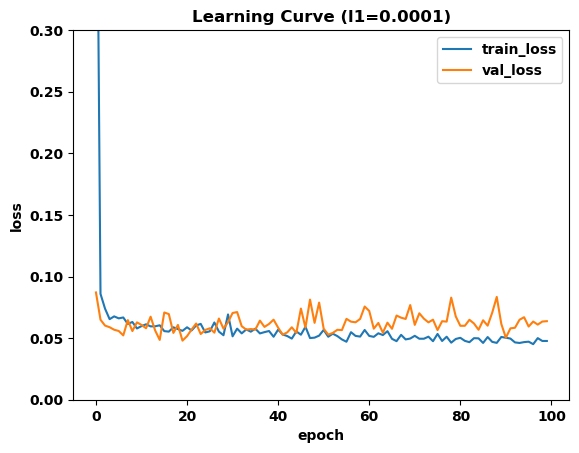

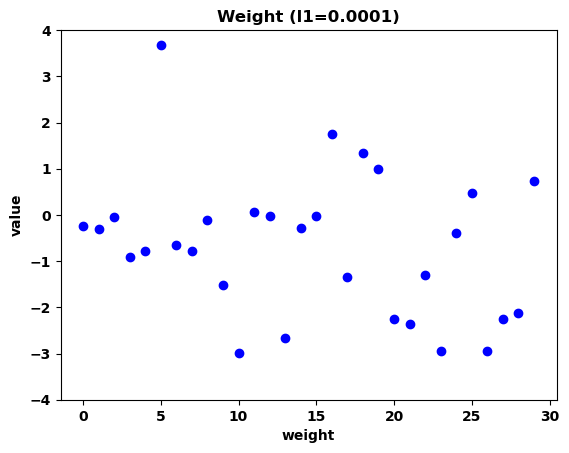

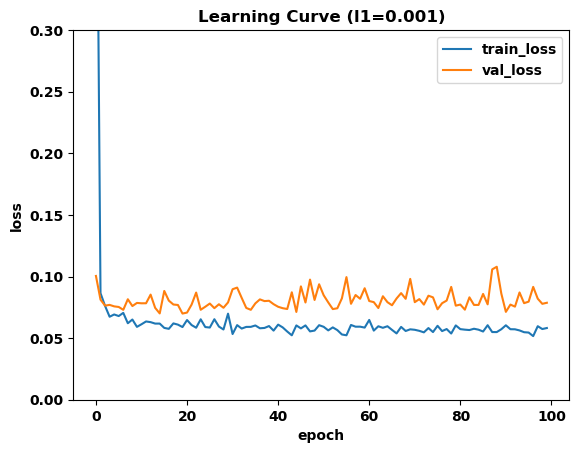

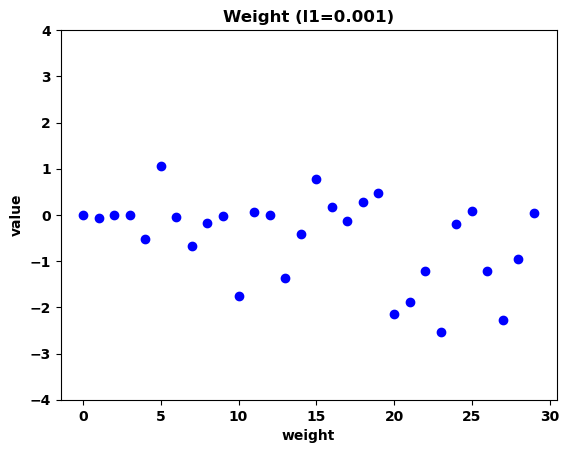

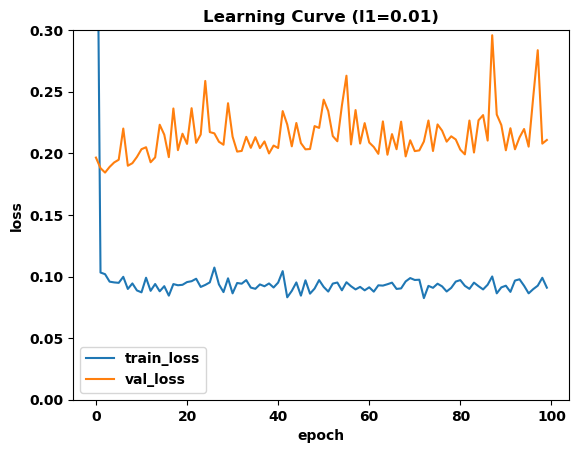

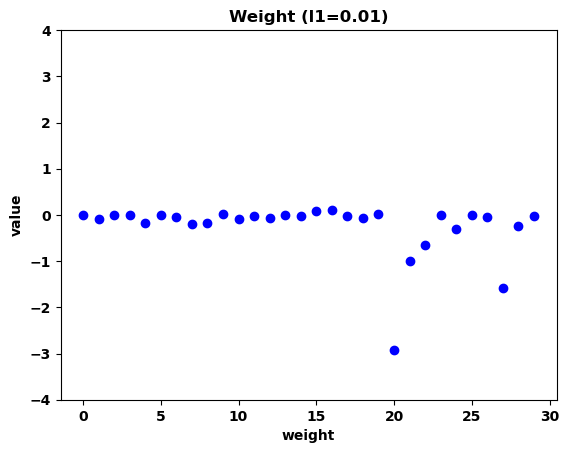

In [48]:
l1_list = [0.0001, 0.001, 0.01]

for l1 in l1_list:
    lyr = SingleLayer(l1=l1)
    lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title(f'Learning Curve (l1={l1})')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'])
    plt.ylim(0, 0.3)
    plt.show()

    plt.plot(lyr.w, 'bo')
    plt.title(f'Weight (l1={l1})')
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4, 4)
    plt.show()

규제가 커질수록 훈련 세트의 손실과 검증 세트의 손실이 모두 높아진다.(과소적합)

In [49]:
# l1=0.001 규제 모델 성능 확인
layer5 = SingleLayer(l1=0.001)
layer5.fit(x_train_scaled, y_train, epochs=20)
layer5.score(x_val_scaled, y_val)

0.978021978021978

### cancer 데이터 세트에 L2 규제 적용

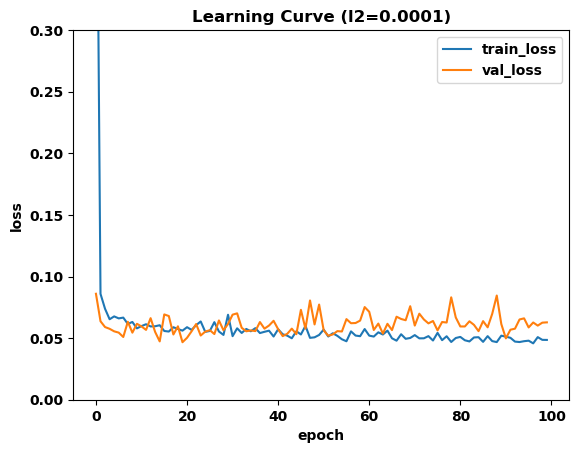

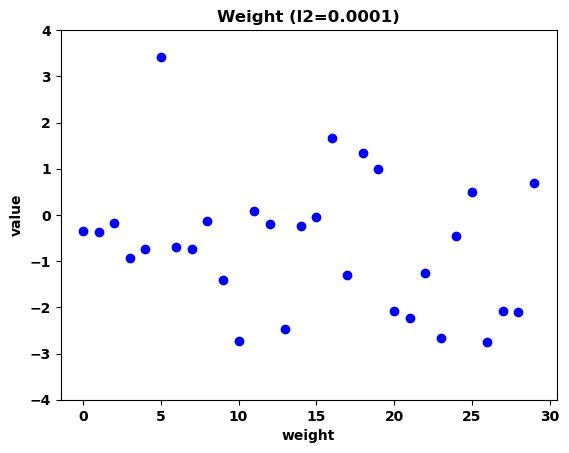

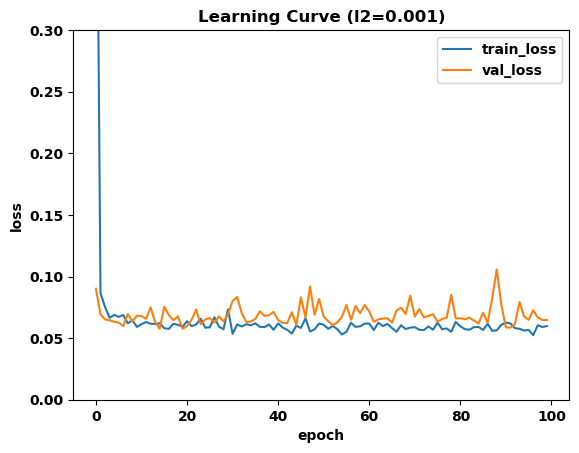

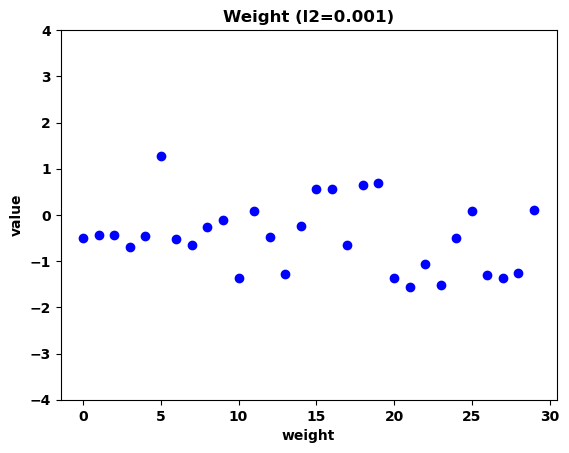

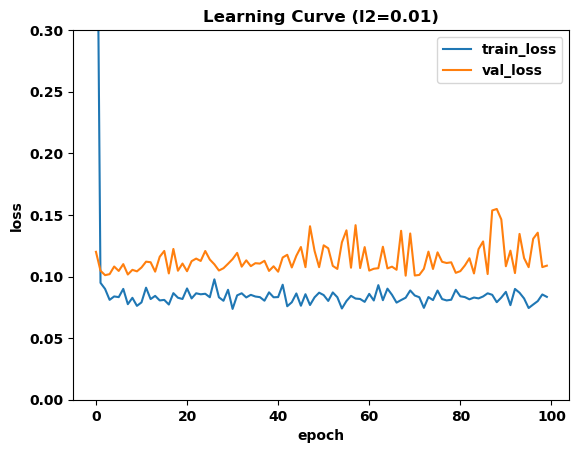

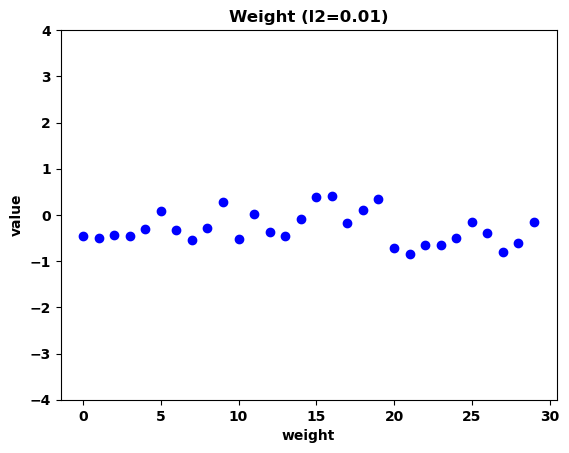

In [51]:
l2_list = [0.0001, 0.001, 0.01]

for l2 in l2_list:
    lyr = SingleLayer(l2=l2)
    lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title(f'Learning Curve (l2={l2})')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'])
    plt.ylim(0, 0.3)
    plt.show()

    plt.plot(lyr.w, 'bo')
    plt.title(f'Weight (l2={l2})')
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4, 4)
    plt.show()

L1 규제와 비슷한 양상을 보인다. 하지만 L1 규제만큼 과소적합이 심해지지는 않는다. 

In [54]:
# l2=0.01 규제 모델 성능 확인
layer6 = SingleLayer(l2=0.02)
layer6.fit(x_train_scaled, y_train, epochs=50)
layer6.score(x_val_scaled, y_val)

0.978021978021978

결과가 L1 규제와 동일하다. cancer 데이터셋의 샘플 개수가 아주 적어서 성능의 큰차이를 못 느낀다.

### SGDClassifier에서 규제 사용

In [55]:
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
sgd.fit(x_train_scaled, y_train)
sgd.score(x_val_scaled, y_val)

0.978021978021978

# 5-4 교차 검증
폴드: 훈련 세트를 나눈 작은 덩어리 

예시로 훈련세트를 5개의 작은 덩어리로 나눈 뒤, 작은 덩어리를 1번씩 검증에 사용하고 나머지 덩어리를 훈련에 사용하는 방법을 `5-폴드 교차 검증`이라 한다.

과정
* 훈련 세트를 k개의 폴드로 나누다.
* 첫 번째 폴드를 검증세트로 사용하고 나머지를 훈련 세트로 사용한다.
* 모델을 훈련한 다음에 검증 세트로 평가한다.
* 차례대로 다음 폴드를 검증 세트로 사용하여 반복한다.
* k개의 검증 세트로 k번 성능을 평가한 후 계산된 성능의 평균을 내어 최종 성능을 계산한다.

## k-폴드 교차 검증 구현

### 훈련 세트 사용
x_train_all, y_train_all을 훈련과 검증에 쓴다.

In [58]:
x_train = x_train_all
y_train = y_train_all

In [57]:
# 각 폴드의 검증 점수 저장
validation_scores = []

### k-폴드 교차 검증 구현

In [61]:
k = 10
bins = len(x_train) // k

for i in range(k):
    start = i * bins
    end = (i+1) * bins
    val_fold = x_train_all[start:end]
    val_target = y_train_all[start:end]

    train_index = list(range(0, start)) + list(range(end, len(x_train)))
    train_fold = x_train_all[train_index]
    train_target = y_train_all[train_index]

    train_mean = np.mean(train_fold, axis=0)
    train_std = np.std(train_fold, axis=0)
    train_fold_scaled = (train_fold - train_mean) / train_std
    val_fold_scaled = (val_fold - train_mean) / train_std

    lyr = SingleLayer(l2=0.01)
    lyr.fit(train_fold_scaled, train_target, epochs=50)
    score = lyr.score(val_fold_scaled, val_target)
    validation_scores.append(score)

print(np.mean(validation_scores))


0.971111111111111


## 사이킷런으로 교차 검증

### cross_validate() 함수로 교차 검증 점수 계산


In [63]:
from sklearn.model_selection import cross_validate
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
scores = cross_validate(sgd, x_train_all, y_train_all, cv=10)
print(np.mean(scores['test_score']))

0.850096618357488


## 전처리 단계 포함 교차 검증 수행

### Pipeline 클래스 사용해 교차 검증 수행

In [64]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), sgd)
scores = cross_validate(pipe, x_train_all, y_train_all, cv=10, return_train_score=True)
print(np.mean(scores['test_score']))

0.9694202898550724


In [65]:
print(np.mean(scores['train_score']))

0.9875478561631581
